In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:07<00:00, 39.6MB/s]
100% 2.29G/2.29G [01:07<00:00, 36.4MB/s]


In [3]:
import zipfile
zip_ext = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ext.extractall('/content')
zip_ext.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout

In [5]:
train_ds = keras.utils.image_dataset_from_directory(
    '/content/chest_xray/train',
    image_size = (256,256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'int'

)

test_ds = keras.utils.image_dataset_from_directory(
    '/content/chest_xray/test',
    image_size = (256,256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'binary'

)

val_ds = keras.utils.image_dataset_from_directory(
    '/content/chest_xray/val',
    image_size = (256,256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'binary'

)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [6]:
import matplotlib.pyplot as plt

([<matplotlib.patches.Wedge at 0x7abed0047a90>,
 [Text(-1.0768670906484026, 0.40355578186719787, 'train'),
  Text(1.023306276583389, -0.4035396688121763, 'test'),
  Text(1.0998396687459067, -0.01878039011560862, 'val')],
 [Text(-0.6086640077577927, 0.22809674627276397, '88.6%'),
  Text(0.5581670599545757, -0.2201125466248234, '10.9%'),
  Text(0.5999125465886763, -0.010243849153968337, '0.5%')])

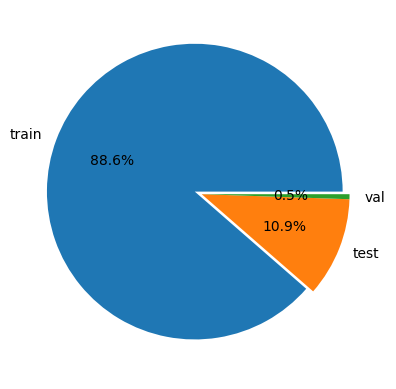

In [7]:
plt.pie([len(train_ds),len(test_ds),len(val_ds)],labels = ['train','test','val'],autopct= '%.1f%%',explode = (0.05, 0, 0))

In [8]:
print(train_ds.class_names)
print(val_ds.class_names)
print(test_ds.class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


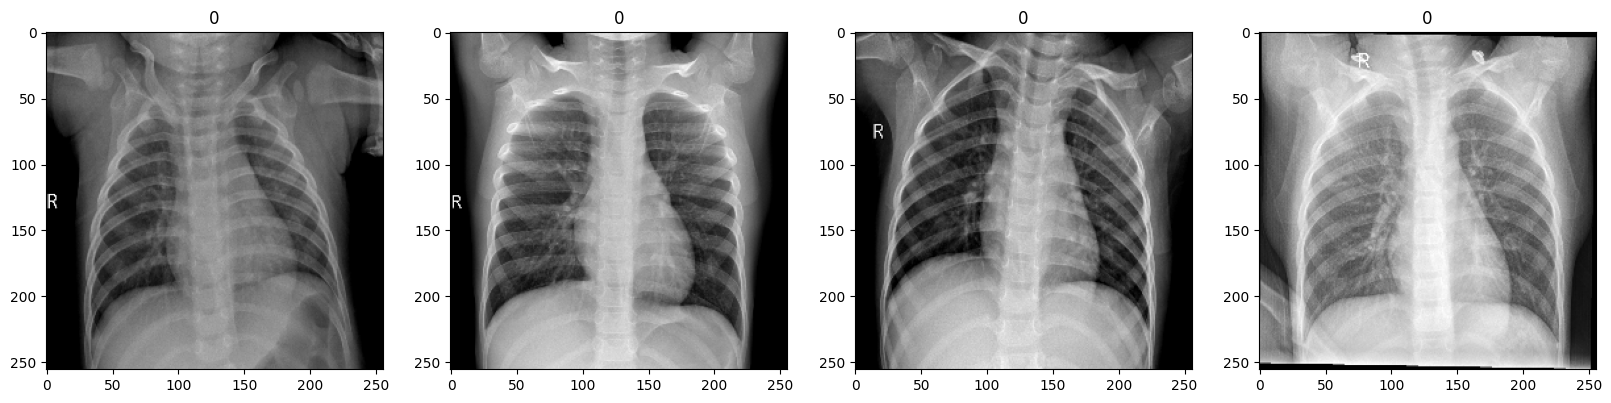

In [9]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:

def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label
train_ds = train_ds.map(process)
test_ds = test_ds.map(process)
val_ds = val_ds.map(process)

In [11]:
from keras.applications.vgg16 import VGG16

In [12]:
conv_base = VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape=(256,256,3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [14]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())



model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(Dropout(0.3))



model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18,909,249
Trainable params: 11,273,985
Non-trainable params: 7,635,264
_________________________________________________________________


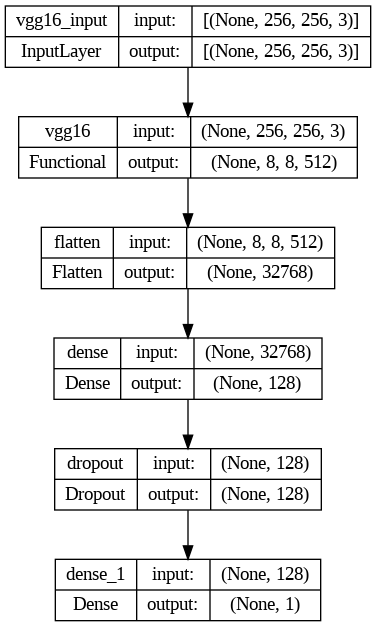

In [15]:
keras.utils.plot_model(model, show_shapes=True)

In [17]:
history = model.fit(train_ds,epochs=10,validation_data =val_ds)

Epoch 1/10
163/163 [==============================] - 48s 280ms/step - loss: 1.0164 - accuracy: 0.9139 - val_loss: 0.1932 - val_accuracy: 0.9375
Epoch 2/10
163/163 [==============================] - 38s 219ms/step - loss: 0.1412 - accuracy: 0.9682 - val_loss: 0.1720 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 38s 222ms/step - loss: 0.1037 - accuracy: 0.9812 - val_loss: 0.0605 - val_accuracy: 1.0000
Epoch 4/10
163/163 [==============================] - 36s 214ms/step - loss: 0.0439 - accuracy: 0.9893 - val_loss: 0.0972 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 38s 221ms/step - loss: 0.0860 - accuracy: 0.9866 - val_loss: 0.0740 - val_accuracy: 1.0000
Epoch 6/10
163/163 [==============================] - 38s 223ms/step - loss: 0.0457 - accuracy: 0.9916 - val_loss: 0.4200 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 39s 228ms/step - loss: 0.0488 - accuracy: 0.9910 - val_loss: 0.0237 - val_ac

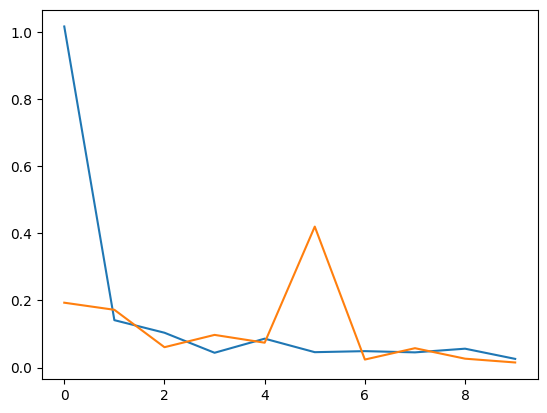

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

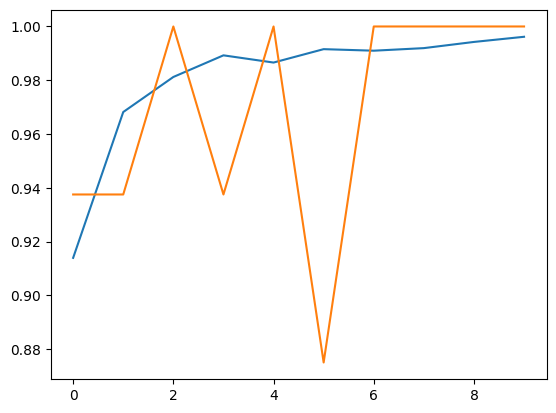

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])